## **imbalanced data**

En los problemas de clasificación en donde tenemos que etiquetar por ejemplo entre “spam” o “not spam” ó entre múltiples categorías (coche, barco, avión) solemos encontrar que en nuestro conjunto de datos de entrenamiento contamos con que alguna de las clases de muestra es una clase “minoritaria” es decir, de la cual tenemos muy poquitas muestras. Esto provoca un desbalanceo en los datos que utilizaremos para el entrenamiento de nuestra máquina.

- En el área de Salud se encuentran conjuntos de datos con miles de registros con pacientes “negativos” y unos pocos casos positivos es decir, que padecen la enfermedad que queremos clasificar.

- Detección de fraude donde tenemos muchas muestras de clientes “honestos” y pocos casos etiquetados como fraudulentos. 


¿Cómo las afectan los datos desbalanceados?


Por lo general afecta a los algoritmos en su proceso de generalización de la información y perjudicando a las clases minoritarias. 




Métricas y Confusion Matrix
Como decía, si medimos la efectividad de nuestro modelo por la cantidad de aciertos que tuvo, sólo teniendo en cuenta a la clase mayoritaria podemos estar teniendo una falsa sensación de que el modelo funciona bien.

Para poder entender esto un poco mejor, utilizaremos la llamada “Confusión matrix” que nos ayudará a comprender las salidas de nuestra máquina:

<img src="https://www.aprendemachinelearning.com/wp-content/uploads/2019/05/confusion_matix_example.png">

<img src="https://www.aprendemachinelearning.com/wp-content/uploads/2019/05/confusion_matix_example.png">


<img src="https://www.aprendemachinelearning.com/wp-content/uploads/2019/05/confusion_matix_example-2.png">

- **Accuracy** del modelo es básicamente el numero total de predicciones correctas dividido por el número total de predicciones. En este caso da 99% cuando no hemos logrado identificar ningún perro.

- **La Precisión** de una clase define cuan confiable es un modelo en responder si un punto pertenece a esa clase. Para la clase gato será del 99% sin embargo para la de perro será 0%.

- **El Recall** de una clase expresa cuan bien puede el modelo detectar a esa clase. Para gatos será de 1 y para perros 0.

- El **F1 Score** de una clase es dada por la media harmonía de precisión y recall (2 x precision x recall / (precision+recall)) digamos que combina precisión y recall en una sola métrica. En nuestro caso daría cero para perros!.

---
#### Cuatro casos posibles para cada clase:

- Alta precision y alto recall: el modelo maneja perfectamente esa clase
- Alta precision y bajo recall: el modelo no detecta la clase muy bien, pero cuando lo hace es altamente confiable.
- Baja precisión y alto recall: La clase detecta bien la clase pero también incluye muestras de otras clases.
- Baja precisión y bajo recall: El modelo no logra clasificar la clase correctamente.
Cuando tenemos un dataset con desequilibrio, suele ocurrir que obtenemos un alto valor de precisión en la clase Mayoritaria y un bajo recall en la clase Minoritaria
---

In [1]:
!pip install imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier

from pylab import rcParams

from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedBaggingClassifier

from collections import Counter


rcParams['figure.figsize'] = 14, 8.7 
LABELS = ["Normal","Fraud"]

%matplotlib inline

In [4]:
df = pd.read_csv("https://github.com/nsethi31/Kaggle-Data-Credit-Card-Fraud-Detection/raw/master/creditcard.csv") 
df.head(n=5) 

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
df.shape

(284807, 31)

In [6]:
pd.value_counts(df['Class'], sort = True) #clase 0=Normal 1=Fraude


0    284315
1       492
Name: Class, dtype: int64

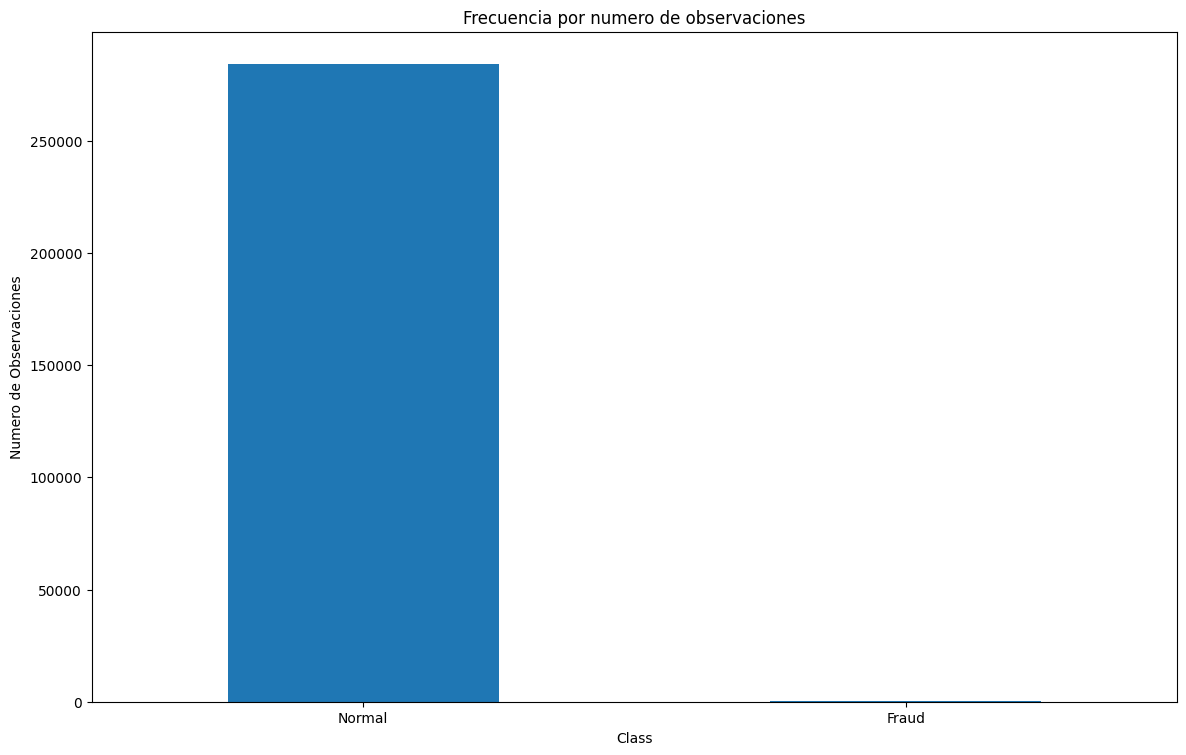

In [7]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.xticks(range(2), LABELS)
plt.title("Frecuencia por numero de observaciones")
plt.xlabel("Class")
plt.ylabel("Numero de Observaciones");

In [8]:
normal_df = df[df.Class == 0] 
fraud_df = df[df.Class == 1] 

##Estrategias para el manejo de Datos Desbalanceados:

- Ajuste de Parámetros del modelo: Consiste en ajustar parametros ó metricas del propio algoritmo para intentar equilibrar a la clase minoritaria penalizando a la clase mayoritaria durante el entrenamiento. 

- Modificar el Dataset: podemos eliminar muestras de la clase mayoritaria para reducirlo e intentar equilibrar la situación. Tiene como “peligroso” que podemos prescindir de muestras importantes, que brindan información y por lo tanto empeorar el modelo. 

- Muestras artificiales: intentar crear muestras sintéticas (no idénticas) utilizando diversos algoritmos que intentan seguir la tendencia del grupo minoritario. Según el método, podemos mejorar los resultados. Lo peligroso de crear muestras sintéticas es que podemos alterar la distribución “natural” de esa clase y confundir al modelo en su clasificación.

- Balanced Ensemble Methods: Utiliza las ventajas de hacer ensamble de métodos, es decir, entrenar diversos modelos y entre todos obtener el resultado final (por ejemplo “votando”) pero se asegura de tomar muestras de entrenamiento equilibradas.
Apliquemos estas técnicas de a una a nuestro código y veamos los resultados.

In [9]:
y = df['Class']
X = df.drop('Class', axis=1)
#dividimos en sets de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)
 
 # import linrary
from xgboost import XGBClassifier

xgb_model = XGBClassifier().fit(X_train, y_train)

# predict
pred_y = xgb_model.predict(X_test)

print (classification_report(y_test, pred_y))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85279
           1       0.94      0.79      0.86       164

    accuracy                           1.00     85443
   macro avg       0.97      0.89      0.93     85443
weighted avg       1.00      1.00      1.00     85443



<Axes: >

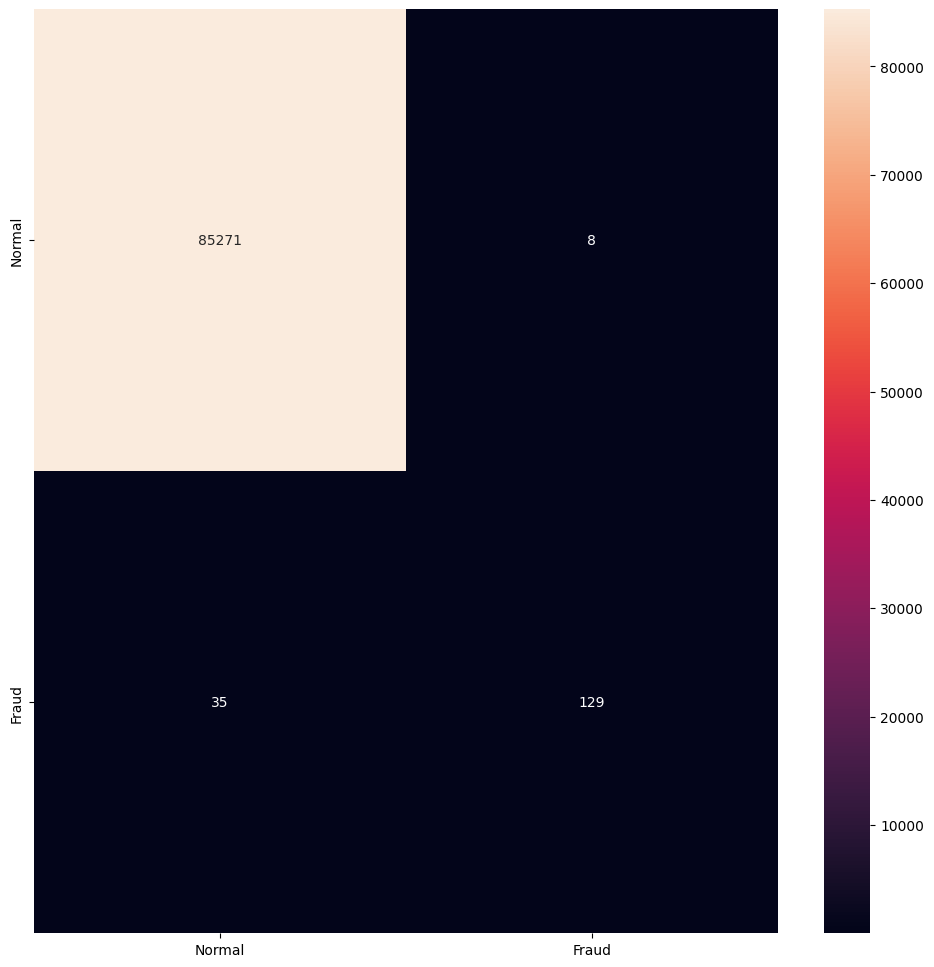

In [10]:
conf_matrix = confusion_matrix(y_test, pred_y)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d")

- En la clase 2  vemos ---- fallos y ---- aciertos dando un recall de ---- 

- También es interesante notar que en la columna de f1-score obtenemos muy buenos resultados PERO que realmente no nos deben engañar… pues están reflejando una realidad parcial. 

- Lo cierto es que nuestro modelo no es capaz de detectar correctamente los casos de Fraude.

In [11]:
# class count
class_count_0, class_count_1 = df['Class'].value_counts()

# Separar las clases
class_0 = df[df['Class'] == 0]
class_1 = df[df['Class'] == 1]
print('class 0:', class_0.shape)
print('class 1:', class_1.shape)

class 0: (284315, 31)
class 1: (492, 31)


## Técnica de remuestreo

Una técnica ampliamente adoptada para manejar conjuntos de datos altamente desequilibrados se llama remuestreo. Consiste en quitar muestras de la clase mayoritaria (under-sampling) y/o añadir más muestras de la clase minoritaria (over-sampling).

<img src="https://miro.medium.com/max/725/1*H6XodlitlGDl9YdbwaZLMw.png">


A pesar de la ventaja de equilibrar las clases, estas técnicas también tienen sus debilidades

- La implementación más simple del sobremuestreo es duplicar registros aleatorios de la clase minoritaria, lo que puede causar sobrepesca.

- En el submuestreo , la técnica más sencilla consiste en eliminar registros aleatorios de la clase mayoritaria, lo que puede provocar la pérdida de información.


1. ## Submuestreo aleatorio

El submuestreo se puede definir como la eliminación de algunas observaciones de la clase mayoritaria . Esto se hace hasta que la clase mayoritaria y minoritaria se equilibra.



total claseds de 1 y 0: 0    492
1    492
Name: Class, dtype: int64


<Axes: title={'center': 'count (target)'}>

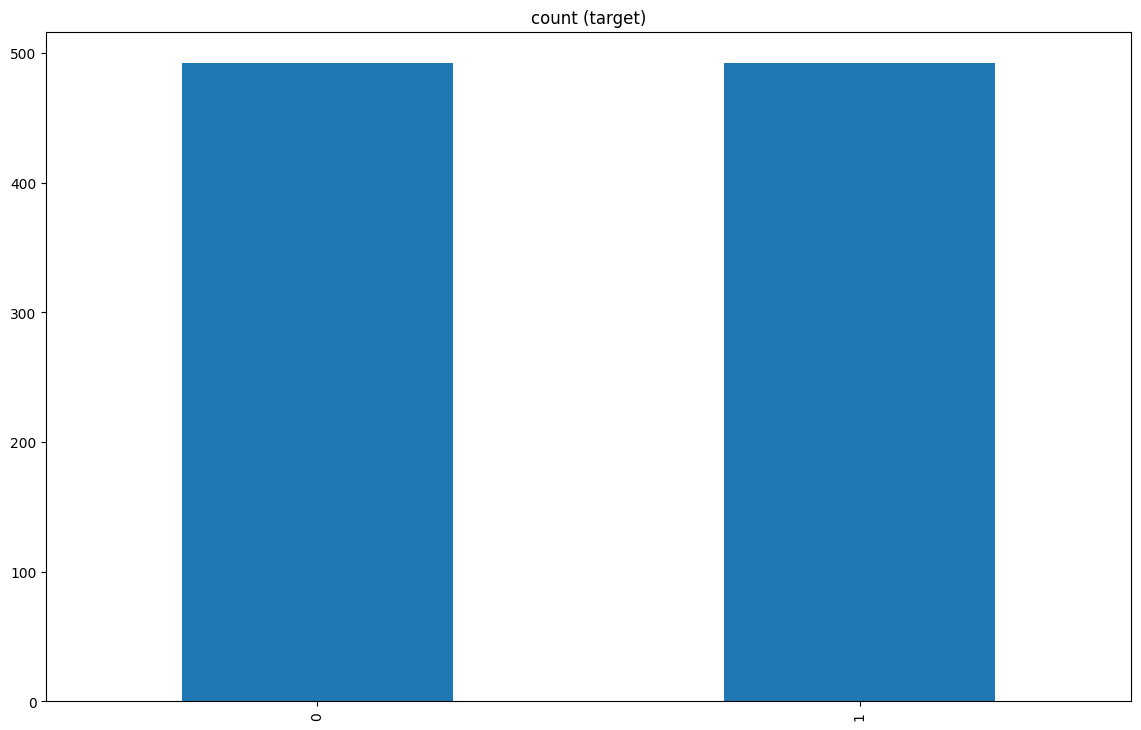

In [12]:
class_0_under = class_0.sample(class_count_1)

test_under = pd.concat([class_0_under, class_1], axis=0)

print("total claseds de 1 y 0:",test_under['Class'].value_counts())
test_under['Class'].value_counts().plot(kind='bar', title='count (target)')

## Sobremuestreo aleatorio
El sobremuestreo se puede definir como agregar más copias a la clase minoritaria. El sobremuestreo puede ser una buena opción cuando no tiene muchos datos con los que trabajar.

Una desventaja a tener en cuenta cuando se realiza un submuestreo es que puede causar un sobreajuste y una mala generalización de su conjunto de prueba.

total class of 1 and 0: 0    492
1    492
Name: Class, dtype: int64


<Axes: title={'center': 'count (target)'}>

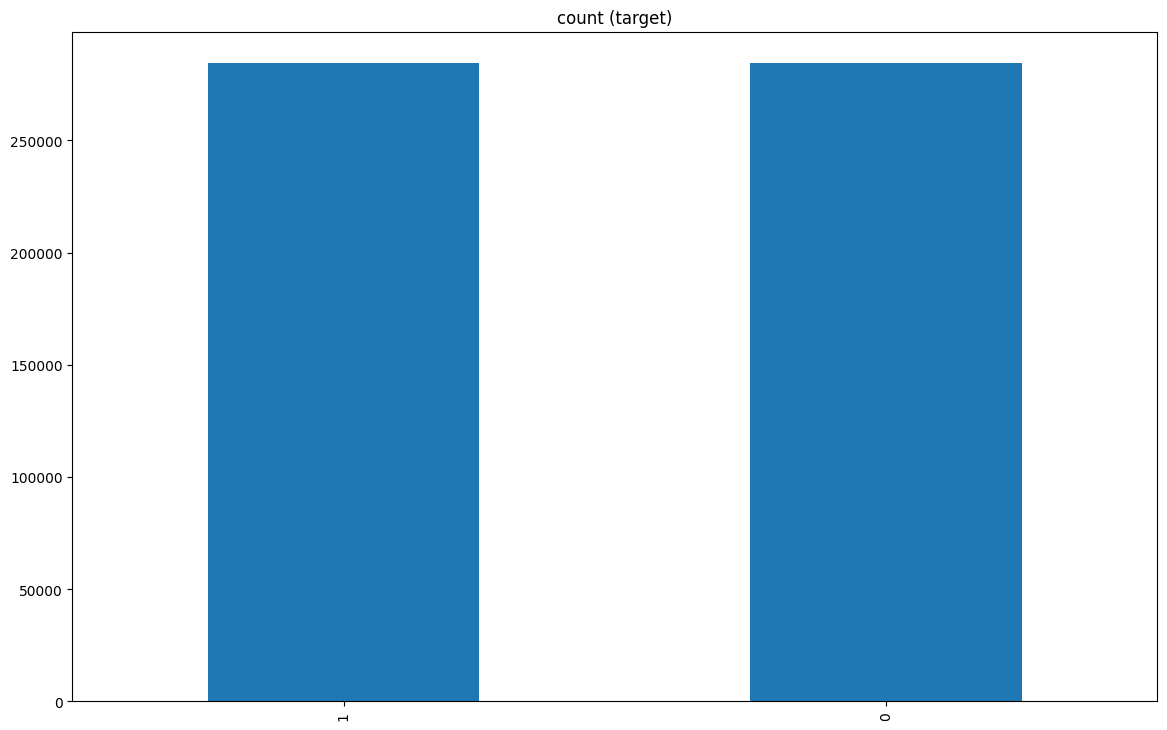

In [13]:
class_1_over = class_1.sample(class_count_0, replace=True)

test_over = pd.concat([class_1_over, class_0], axis=0)

print("total class of 1 and 0:",test_under['Class'].value_counts())# plot the count after under-sampeling
test_over['Class'].value_counts().plot(kind='bar', title='count (target)')

## Equilibre los datos imblearn


Agrupar los registros de la clase mayoritaria y hacer el submuestreo eliminando registros de cada grupo, buscando así preservar la información. En el sobremuestreo, en lugar de crear copias exactas de los registros de las clases minoritarias, podemos introducir pequeñas variaciones en esas copias, creando muestras sintéticas más diversas.



In [14]:
import imblearn


## 3. Submuestreo aleatorio con imblearn
RandomUnderSampleres una forma rápida y sencilla de equilibrar los datos seleccionando aleatoriamente un subconjunto de datos para las clases objetivo. Muestrear por debajo de la(s) clase(s) mayoritaria(s) seleccionando muestras al azar con o sin reemplazo.

In [15]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42, replacement=True)
x_rus, y_rus = rus.fit_resample(X_train, y_train)

print('original dataset shape:', Counter(y))
print('Resample dataset shape', Counter(y_rus))

original dataset shape: Counter({0: 284315, 1: 492})
Resample dataset shape Counter({0: 328, 1: 328})


## Sobremuestreo aleatorio con imblearn

Una forma de combatir los datos desequilibrados es generar nuevas muestras en las clases minoritarias. La estrategia  es generar nuevas muestras mediante muestreo aleatorio con reemplazo de las muestras actualmente disponibles. Las RandomOverSamplerofertas de tal esquema.

In [17]:
# import library
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)

# ajustar predictor y variable objetivo
x_ros, y_ros = ros.fit_resample(X_train, y_train)

print('Original dataset shape', Counter(y_train))
print('Resample dataset shape', Counter(y_ros))

Original dataset shape Counter({0: 199036, 1: 328})
Resample dataset shape Counter({0: 199036, 1: 199036})


## 5. Submuestreo: enlaces Tomek
Los enlaces Tomek son pares de instancias muy cercanas pero de clases opuestas. Eliminar las instancias de la clase mayoritaria de cada par aumenta el espacio entre las dos clases, lo que facilita el proceso de clasificación.

El enlace de Tomek existe si las dos muestras son los vecinos más cercanos entre sí


<img src="https://miro.medium.com/max/640/1*KxFmI15rxhvKRVl-febp-Q.png">


In [18]:
from imblearn.under_sampling import TomekLinks

tl = RandomOverSampler(sampling_strategy='majority')

# predictor de ajuste y variable objetivo
x_tl, y_tl = ros.fit_resample(X_train, y_train)

print('Original dataset shape', Counter(y_train))
print('Resample dataset shape', Counter(y_tl))

Original dataset shape Counter({0: 199036, 1: 328})
Resample dataset shape Counter({0: 199036, 1: 199036})


## 6.Técnica de sobremuestreo minoritario sintético (SMOTE)
Esta técnica genera datos sintéticos para la clase minoritaria.

SMOTE (técnica de sobremuestreo de minorías sintéticas) funciona seleccionando aleatoriamente un punto de la clase minoritaria y calculando los k-vecinos más cercanos para este punto. 

<img src="https://miro.medium.com/max/734/1*yRumRhn89acByodBz0H7oA.png">

 Los puntos sintéticos se suman entre el punto elegido y sus vecinos.

algoritmo SMOTE funciona:

- Elija una clase minoritaria como vector de entrada
- Encuentre sus k vecinos más cercanos ( k_neighbors se especifica como un argumento en la función SMOTE() )
- Elija uno de estos vecinos y coloque un punto sintético en cualquier lugar de la línea que une el punto en consideración y su vecino elegido
- Repita los pasos hasta que los datos estén equilibrados.

In [19]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()

# Ajuste del predicto y variable objetivo
x_smote, y_smote = smote.fit_resample(X_test, y_test)

print('Original dataset shape', Counter(y))
print('Resample dataset shape', Counter(y_smote))

Original dataset shape Counter({0: 284315, 1: 492})
Resample dataset shape Counter({0: 85279, 1: 85279})


## 7. NearMiss
NearMiss es una técnica de submuestreo. En lugar de volver a muestrear la clase minoritaria, usando una distancia, esto hará que la clase mayoritaria sea igual a la clase minoritaria.

In [20]:
from imblearn.under_sampling import NearMiss

nm = NearMiss()

x_nm, y_nm = nm.fit_resample(X_train, y_train)

print('Original dataset shape:', Counter(y_train))
print('Resample dataset shape:', Counter(y_nm))

Original dataset shape: Counter({0: 199036, 1: 328})
Resample dataset shape: Counter({0: 328, 1: 328})


## 8. Cambia la métrica de rendimiento
La precisión no es la mejor métrica para usar al evaluar conjuntos de datos desequilibrados, ya que puede ser engañosa.

Las métricas que pueden proporcionar una mejor perspectiva son:

- Matriz de confusión: una tabla que muestra las predicciones correctas y los tipos de predicciones incorrectas.

- Precisión: el número de verdaderos positivos dividido por todas las predicciones positivas. La precisión también se denomina valor predictivo positivo. Es una medida de la exactitud de un clasificador. La baja precisión indica un alto número de falsos positivos.

- Recall: el número de verdaderos positivos dividido por el número de valores positivos en los datos de prueba. El retiro también se llama Sensibilidad o Tasa de verdaderos positivos. Es una medida de la integridad de un clasificador. Un recuerdo bajo indica un alto número de falsos negativos.


- F1 Score: el promedio ponderado de precisión y recuperación.
- Área bajo la curva ROC (AUROC): AUROC representa la probabilidad de que su modelo distinga las observaciones de dos clases.
En otras palabras, si selecciona al azar una observación de cada clase, ¿cuál es la probabilidad de que su modelo pueda "clasificarlas" correctamente?

## Cambiar el algoritmo

Aunque en todos los problemas de aprendizaje automático es una buena regla general probar varios algoritmos, puede ser especialmente beneficioso con conjuntos de datos desequilibrados.

Los árboles de decisión suelen funcionar bien con datos desequilibrados. En el aprendizaje automático moderno, los conjuntos de árboles (Random Forests, Gradient Boosted Trees, etc.) casi siempre superan a los árboles de decisión singulares, así que pasaremos directamente a ellos:

Los algoritmos basados en árboles funcionan aprendiendo una jerarquía de preguntas if/else. 


In [21]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
# data_0 = data_0.sample(n=9000)

KeyboardInterrupt: ignored

In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score

In [ ]:
# prediccion
rfc_predict = rfc.predict(X_test)
print('ROCAUC score:',roc_auc_score(y_test, rfc_predict))
print('Accuracy score:',accuracy_score(y_test, rfc_predict))
print('F1 score:',f1_score(y_test, rfc_predict))

In [ ]:
conf_matrix_rf = confusion_matrix(y_test, rfc_predict)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix_rf, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d")

In [ ]:
print(classification_report(y_test, rfc_predict))

## Penalizar algoritmos (entrenamiento sensible al costo)
La siguiente táctica es utilizar algoritmos de aprendizaje penalizados que aumentan el costo de los errores de clasificación en la clase minoritaria.

Un algoritmo popular para esta técnica es Penalized-SVM.

Durante el entrenamiento, podemos usar el argumento class_weight=’balanced’para penalizar los errores de la clase minoritaria en una cantidad proporcional a cuán subrepresentada está.

También queremos incluir el argumento probability=True si queremos habilitar estimaciones de probabilidad para algoritmos SVM.



In [ ]:
from sklearn.svm import SVC


svc_model = SVC(class_weight='balanced', probability=True)

svc_model.fit(X_train, y_train)

svc_predict = svc_model.predict(X_test)# check performance
print('ROCAUC score:',roc_auc_score(y_test, svc_predict))
print('Accuracy score:',accuracy_score(y_test, svc_predict))
print('F1 score:',f1_score(y_test, svc_predict))